# Imagenet - SGD With Momentum Optimizer

|S.No.|Optimization|Architecture|Pretrained|Pre-processing|Batch Count|Epochs|Loss Function|Optimizer|LR|Scheduler|Time per epoch|Test Acc|Val Acc|Overfitting| Underfitting|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|1|Basic|Resnet50|No|Convert To Tensor|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.84|68.33|Yes|No|
|2|Resize Image|Resnet50|No|Resize Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.86|69.89|Yes|No|
|3|Normalized Image|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.05|1.30|99.89|70.34|Yes|No|
|4|LR 0.001|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001|1.30|80.27|69.88|Yes|No|
|5|LR 0.001 --> 0.0001/10|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001/0.0001|1.30|68.15|65.15|Yes|No|
|6|Adam Optimizer|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|Adam|None|0.001/0.0001|1.30|99.14|58.27|Yes|No|
|7|RMSProp Optimizer|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|RMSProp|None|0.001/0.0001|1.30|99.14|58.27|Yes|No|
|8|SGD with Momentum|Resnet50|No|Normalized Image|128|30|CrossEntropyLoss|SGD|None|0.001/0.0001|1.30|98.52|69.83|Yes|No|

## Summary
- Overall Val accuracy has been increased to 70%
- After 2-3 epochs Val acc reached 70% and it remained constant.
- Train acc reached 98% in 2-3 epochs leading to overfitting.


## Install Packages

In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118 # Install packages in the correct order
!pip install numpy==1.24.3
!pip install tqdm matplotlib pillow
!pip install seaborn scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu118


## Check for CUDA and set device

In [2]:
# Verify CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA device: Tesla T4
Using device: cuda


## Import all packages

In [3]:
# Import all required libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import urllib.request
import zipfile
import shutil

## Verify installation and important package versions

In [4]:
# Verify installations
import numpy as np
print(f"Numpy version: {np.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")

import torchvision
print(f"Torchvision version: {torchvision.__version__}")

Numpy version: 1.24.3
PyTorch version: 2.4.1+cu118
Torchvision version: 0.19.1+cu118


In [5]:
## Application Constants
BATCH_SIZE = 128
NUM_CLASSES = 200
EPOCHS_COUNT = 30
LR = 0.001

## Download Dataset

In [6]:
# Download and extract Tiny ImageNet
def download_and_extract_tiny_imagenet():
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = "tiny-imagenet-200.zip"
    extract_path = "tiny-imagenet-200"
    
    if not os.path.exists(extract_path):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./")
        
        # Remove the zip file
        os.remove(zip_path)
        print("Dataset ready!")
    else:
        print("Dataset already exists!")
    
    return extract_path

In [7]:
# Prepare validation directory structure
def restructure_val_dir(dataset_path):
    val_dir = os.path.join(dataset_path, 'val')
    val_images_dir = os.path.join(val_dir, 'images')
    
    if os.path.exists(val_images_dir):
        # Read validation annotations file
        val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')
        with open(val_annotations_file, 'r') as f:
            val_annotations = f.readlines()
        
        # Create class directories and move images
        for line in val_annotations:
            parts = line.strip().split('\t')
            img_name, class_id = parts[0], parts[1]
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(val_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            
            # Move image to class directory
            src_path = os.path.join(val_images_dir, img_name)
            dst_path = os.path.join(class_dir, img_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Remove the original images directory and annotations file
        shutil.rmtree(val_images_dir)
        os.remove(val_annotations_file)

In [8]:
# Download and prepare dataset
dataset_path = download_and_extract_tiny_imagenet()
restructure_val_dir(dataset_path)

Dataset already exists!


## Define Transformations

In [9]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Prepare Dataset

In [10]:
# Load datasets
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)


In [11]:
# Create data loaders
batch_size = BATCH_SIZE  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


## Load Resnet50 Model

In [12]:
# Load ResNet50 with pretrained=False for training from scratch
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = NUM_CLASSES
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


## Define Loss Function and Optimizer

In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=.9)

## Train the model

In [14]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [15]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [16]:
# Training loop
num_epochs = EPOCHS_COUNT
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Change LR 0.001 to 0.0001 after 10 epoch
    if epoch+1 > 10:
        optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=.9)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")



Epoch 1/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.75it/s]


Train Loss: 2.8119 | Train Acc: 43.36%
Val Loss: 1.4993 | Val Acc: 63.38%

Epoch 2/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


Train Loss: 1.3158 | Train Acc: 67.25%
Val Loss: 1.2686 | Val Acc: 68.07%

Epoch 3/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.81it/s]


Train Loss: 1.0013 | Train Acc: 74.35%
Val Loss: 1.2019 | Val Acc: 69.68%

Epoch 4/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.10it/s]


Train Loss: 0.7895 | Train Acc: 79.60%
Val Loss: 1.1823 | Val Acc: 70.37%

Epoch 5/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.69it/s]


Train Loss: 0.6231 | Train Acc: 83.91%
Val Loss: 1.1905 | Val Acc: 70.58%

Epoch 6/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


Train Loss: 0.4913 | Train Acc: 87.47%
Val Loss: 1.2232 | Val Acc: 70.25%

Epoch 7/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


Train Loss: 0.3848 | Train Acc: 90.36%
Val Loss: 1.2449 | Val Acc: 70.32%

Epoch 8/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.82it/s]


Train Loss: 0.3004 | Train Acc: 92.67%
Val Loss: 1.2783 | Val Acc: 70.15%

Epoch 9/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.94it/s]


Train Loss: 0.2349 | Train Acc: 94.48%
Val Loss: 1.3070 | Val Acc: 70.47%

Epoch 10/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.79it/s]


Train Loss: 0.1851 | Train Acc: 95.81%
Val Loss: 1.3663 | Val Acc: 69.92%

Epoch 11/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]


Train Loss: 0.1423 | Train Acc: 97.14%
Val Loss: 1.3505 | Val Acc: 70.15%

Epoch 12/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.45it/s]


Train Loss: 0.1334 | Train Acc: 97.34%
Val Loss: 1.3582 | Val Acc: 70.05%

Epoch 13/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.12it/s]


Train Loss: 0.1305 | Train Acc: 97.42%
Val Loss: 1.3549 | Val Acc: 70.22%

Epoch 14/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.93it/s]


Train Loss: 0.1276 | Train Acc: 97.50%
Val Loss: 1.3722 | Val Acc: 70.09%

Epoch 15/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.70it/s]


Train Loss: 0.1232 | Train Acc: 97.56%
Val Loss: 1.3726 | Val Acc: 70.10%

Epoch 16/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.99it/s]


Train Loss: 0.1189 | Train Acc: 97.72%
Val Loss: 1.3715 | Val Acc: 70.08%

Epoch 17/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s]


Train Loss: 0.1158 | Train Acc: 97.74%
Val Loss: 1.3787 | Val Acc: 70.28%

Epoch 18/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.81it/s]


Train Loss: 0.1131 | Train Acc: 97.83%
Val Loss: 1.3912 | Val Acc: 69.93%

Epoch 19/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]


Train Loss: 0.1088 | Train Acc: 97.94%
Val Loss: 1.3848 | Val Acc: 69.88%

Epoch 20/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.05it/s]


Train Loss: 0.1068 | Train Acc: 98.00%
Val Loss: 1.3864 | Val Acc: 70.02%

Epoch 21/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.97it/s]


Train Loss: 0.1035 | Train Acc: 98.07%
Val Loss: 1.3859 | Val Acc: 70.10%

Epoch 22/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.87it/s]


Train Loss: 0.1022 | Train Acc: 98.14%
Val Loss: 1.3992 | Val Acc: 69.99%

Epoch 23/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.81it/s]


Train Loss: 0.1007 | Train Acc: 98.15%
Val Loss: 1.4013 | Val Acc: 69.85%

Epoch 24/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.56it/s]


Train Loss: 0.0969 | Train Acc: 98.23%
Val Loss: 1.4088 | Val Acc: 70.11%

Epoch 25/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s]


Train Loss: 0.0943 | Train Acc: 98.33%
Val Loss: 1.4041 | Val Acc: 69.64%

Epoch 26/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]


Train Loss: 0.0928 | Train Acc: 98.36%
Val Loss: 1.4036 | Val Acc: 69.87%

Epoch 27/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.99it/s]


Train Loss: 0.0905 | Train Acc: 98.38%
Val Loss: 1.4190 | Val Acc: 69.87%

Epoch 28/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.52it/s]


Train Loss: 0.0885 | Train Acc: 98.45%
Val Loss: 1.4265 | Val Acc: 69.44%

Epoch 29/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


Train Loss: 0.0863 | Train Acc: 98.49%
Val Loss: 1.4219 | Val Acc: 69.98%

Epoch 30/30


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.69it/s]

Train Loss: 0.0843 | Train Acc: 98.52%
Val Loss: 1.4375 | Val Acc: 69.83%


## Plot Metrics

In [17]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

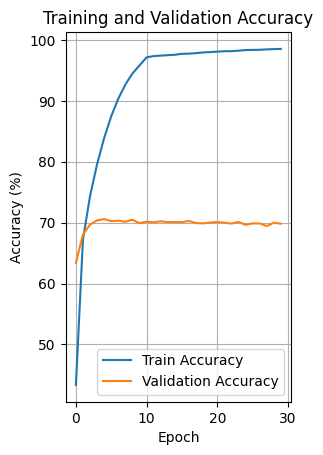

In [18]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

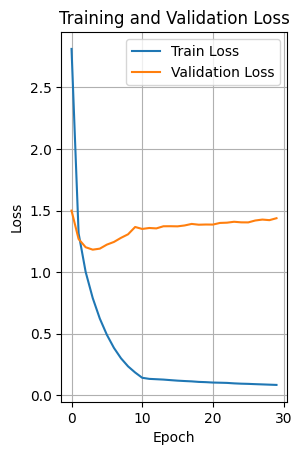

In [19]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Save Model

In [21]:
# Save the model
torch.save(model.state_dict(), 'resnet50_tiny_imagenet.pth')

## Plot Misclassified Images

In [22]:
def get_class_name_mapping(dataset_path):
    """
    Create mapping from wnid to human-readable class names using words.txt
    """
    words_file = os.path.join(dataset_path, 'words.txt')
    wnid_to_name = {}
    
    try:
        with open(words_file, 'r') as f:
            for line in f:
                wnid, names = line.strip().split('\t')
                # Take the first comma-separated name if multiple exist
                name = names.split(',')[0].strip()
                wnid_to_name[wnid] = name
    except FileNotFoundError:
        print(f"Warning: words.txt not found at {words_file}")
        # Create a simple mapping if words.txt is not available
        wnid_to_name = {class_id: class_id for class_id in train_dataset.classes}
    
    return wnid_to_name

In [23]:
def denormalize(tensor):
    """
    Denormalize the image tensor for visualization
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

In [24]:
def get_misclassified_images(model, val_loader, class_mapping, num_images=20):
    """
    Get misclassified images with their true and predicted labels
    """
    model.eval()
    misclassified_images = []
    true_classes = []
    pred_classes = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified images
            mask = (predicted != labels)
            misclassified_idx = mask.nonzero(as_tuple=True)[0]
            
            for idx in misclassified_idx:
                if len(misclassified_images) >= num_images:
                    break
                
                # Get wnids
                true_wnid = train_dataset.classes[labels[idx].item()]
                pred_wnid = train_dataset.classes[predicted[idx].item()]
                
                # Get human-readable names
                true_class_name = class_mapping.get(true_wnid, true_wnid)
                pred_class_name = class_mapping.get(pred_wnid, pred_wnid)
                
                misclassified_images.append(images[idx].cpu())
                true_classes.append(true_class_name)
                pred_classes.append(pred_class_name)
                
            if len(misclassified_images) >= num_images:
                break
    
    return misclassified_images, true_classes, pred_classes

In [25]:
def plot_misclassified(images, true_classes, pred_classes, num_images=20):
    """
    Plot misclassified images in a grid
    """
    if len(images) < num_images:
        num_images = len(images)
    
    num_rows = (num_images + 4) // 5  # 5 images per row
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))
    axes = axes.ravel()
    
    for idx in range(num_images):
        # img = denormalize(images[idx])
        img = images[idx]
        img = torch.clamp(img, 0, 1)
        
        # Format class names
        true_class = true_classes[idx]
        pred_class = pred_classes[idx]
        
        # Truncate long class names
        true_display = true_class[:25] + '...' if len(true_class) > 25 else true_class
        pred_display = pred_class[:25] + '...' if len(pred_class) > 25 else pred_class
        
        axes[idx].imshow(img.permute(1, 2, 0))
        axes[idx].axis('off')
        title = f'True: {true_display}\nPred: {pred_display}'
        axes[idx].set_title(title, fontsize=10, color='red', pad=10)
    
    # Turn off any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Get class name mapping
class_mapping = get_class_name_mapping(dataset_path)

In [27]:
# Get misclassified images
misclassified_images, true_classes, pred_classes = get_misclassified_images(
    model, val_loader, class_mapping
)

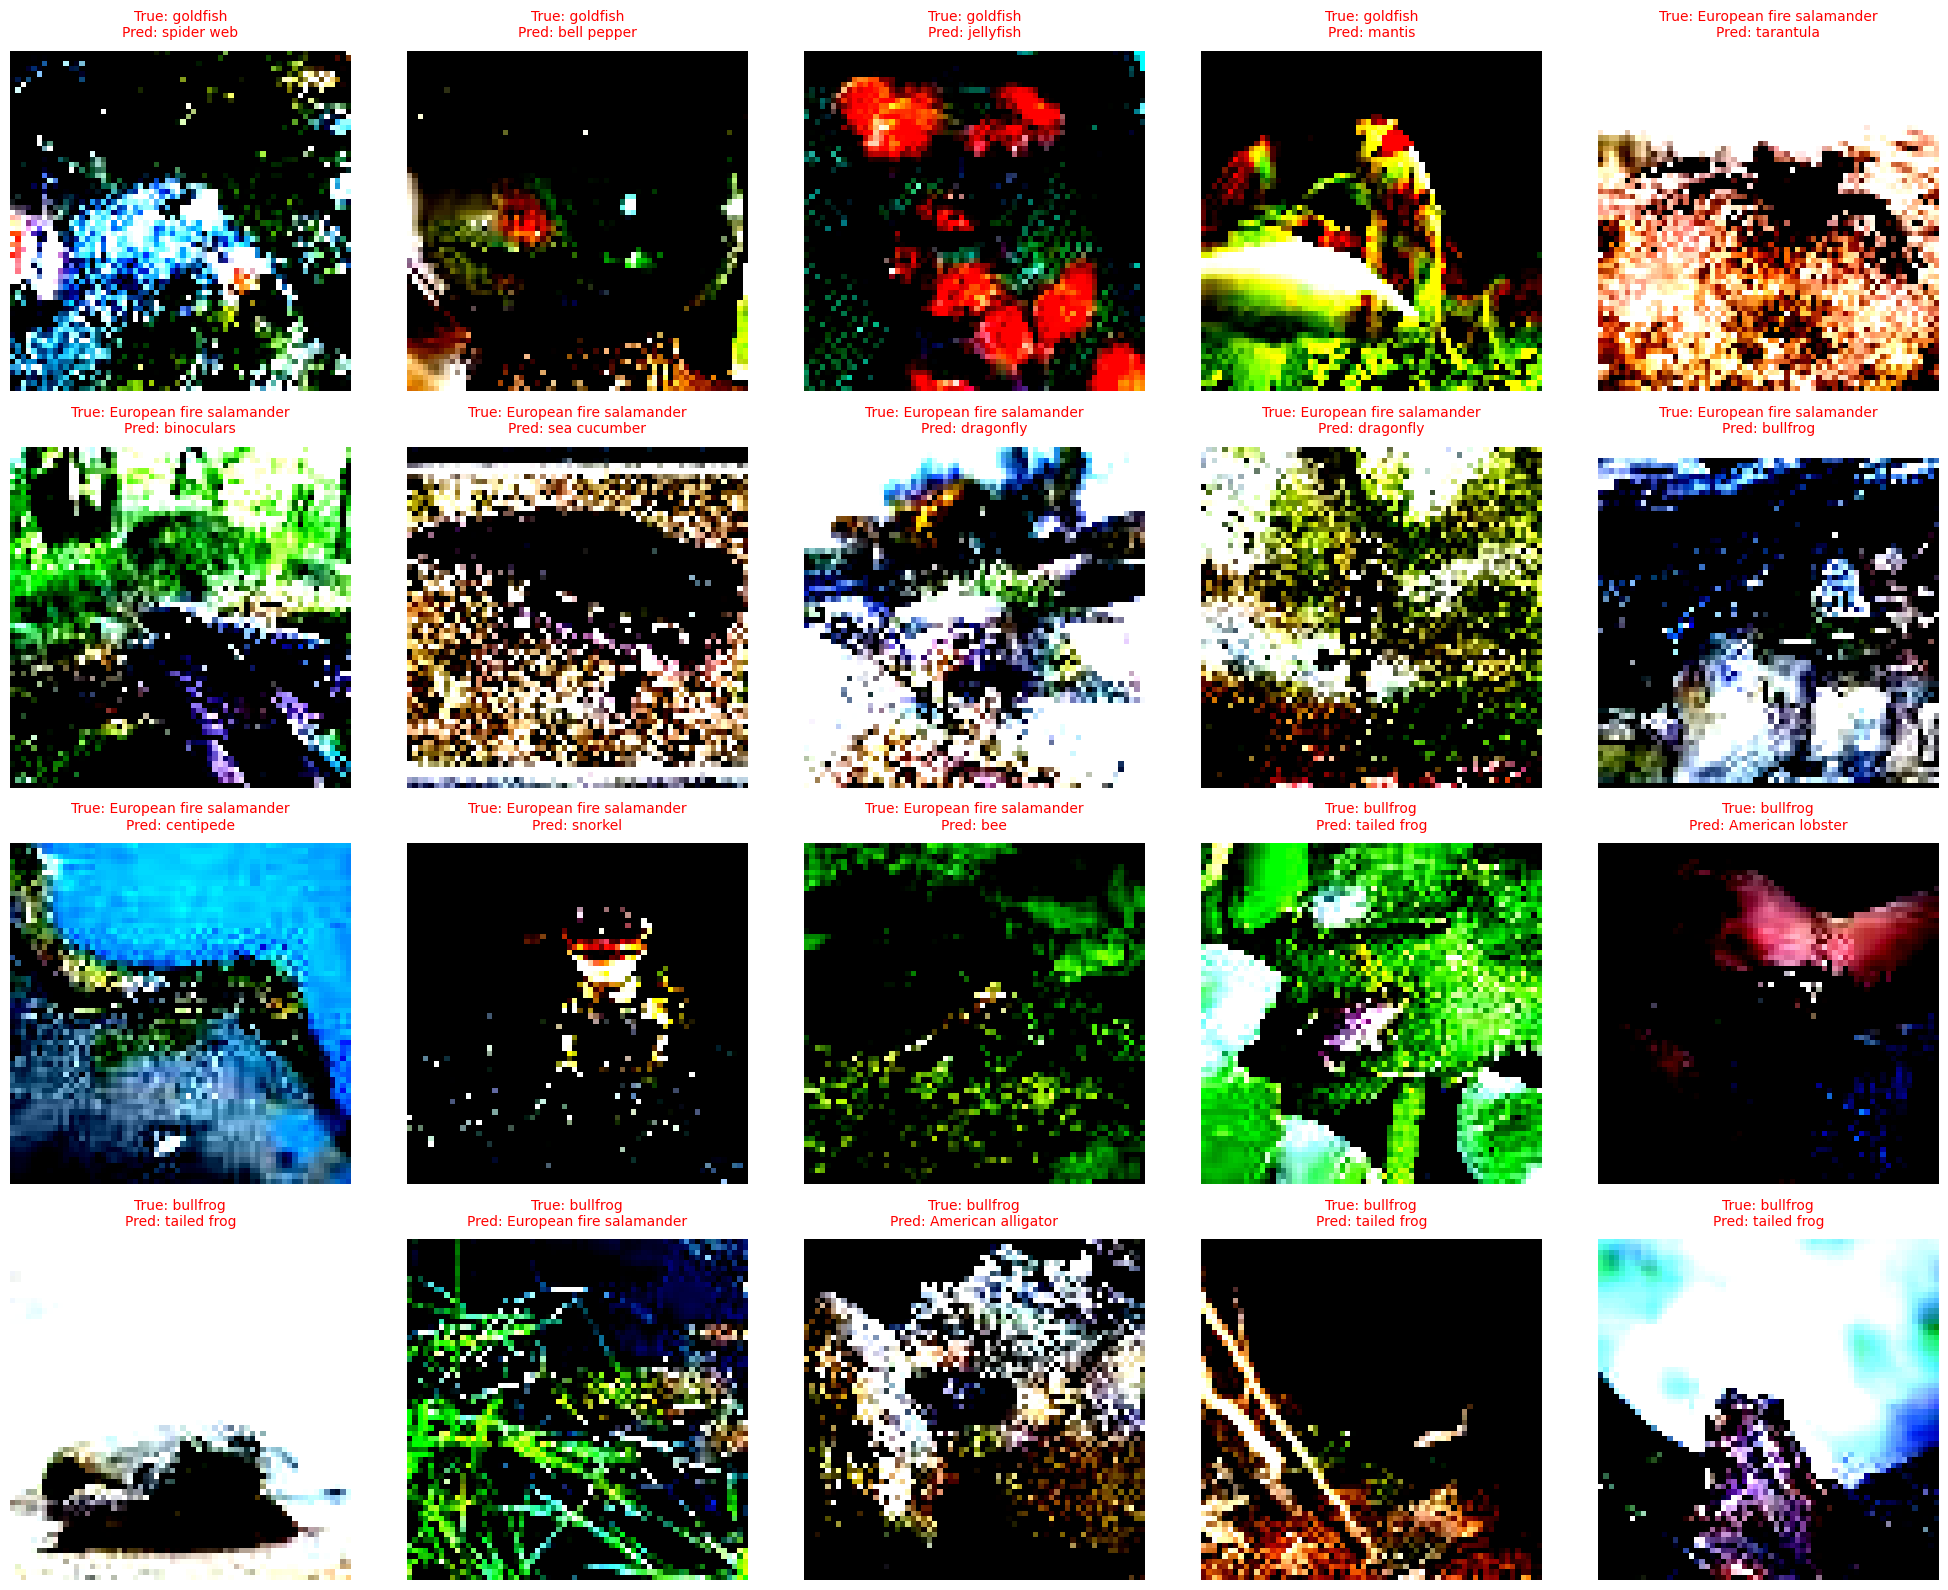

In [28]:
# Plot misclassified images
plot_misclassified(misclassified_images, true_classes, pred_classes)

In [29]:
# Print model accuracy
print("\nEvaluating model on validation set...")
model.eval()
correct = 0
total = 0
class_correct = {}
class_total = {}

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        for label, pred in zip(labels, predicted):
            label_name = class_mapping[train_dataset.classes[label.item()]]
            if label_name not in class_total:
                class_total[label_name] = 0
                class_correct[label_name] = 0
            class_total[label_name] += 1
            if label == pred:
                class_correct[label_name] += 1
                
# Overall accuracy
accuracy = 100 * correct / total
print(f"\nOverall Model Accuracy: {accuracy:.2f}%")

# Print per-class accuracy
print("\nPer-class Accuracy:")
accuracies = []
for class_name in class_total:
    class_acc = 100 * class_correct[class_name] / class_total[class_name]
    accuracies.append((class_name, class_acc))

# Sort by accuracy
accuracies.sort(key=lambda x: x[1], reverse=True)

# Print top 10 and bottom 10 classes
print("\nTop 10 Best Performing Classes:")
for class_name, acc in accuracies[:10]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

print("\nBottom 10 Worst Performing Classes:")
for class_name, acc in accuracies[-10:]:
    print(f"{class_name[:40]:<40}: {acc:.2f}%")

# Analyze misclassifications
print("\nMost Common Misclassifications:")
misclass_count = {}
for true_class, pred_class in zip(true_classes, pred_classes):
    if true_class not in misclass_count:
        misclass_count[true_class] = {}
    if pred_class not in misclass_count[true_class]:
        misclass_count[true_class][pred_class] = 0
    misclass_count[true_class][pred_class] += 1

for true_class in misclass_count:
    print(f"\nTrue class: {true_class}")
    sorted_misclass = sorted(misclass_count[true_class].items(), 
                            key=lambda x: x[1], 
                            reverse=True)
    for pred_class, count in sorted_misclass[:3]:
        print(f"  Predicted as {pred_class}: {count} times")


Evaluating model on validation set...


100%|██████████| 79/79 [00:03<00:00, 21.83it/s]


Overall Model Accuracy: 69.83%

Per-class Accuracy:

Top 10 Best Performing Classes:
dugong                                  : 96.00%
gazelle                                 : 96.00%
monarch                                 : 94.00%
goldfish                                : 92.00%
king penguin                            : 92.00%
school bus                              : 92.00%
jellyfish                               : 90.00%
brown bear                              : 90.00%
gondola                                 : 90.00%
trolleybus                              : 90.00%

Bottom 10 Worst Performing Classes:
barbershop                              : 48.00%
syringe                                 : 48.00%
convertible                             : 46.00%
umbrella                                : 46.00%
wooden spoon                            : 46.00%
pole                                    : 44.00%
reel                                    : 44.00%
water jug                               : 44

## ChatGPT

The behavior you're describing, where the **training accuracy reaches 98%** after just 2 epochs, but the **validation accuracy improves initially** and then **stays constant**, suggests that the model is starting to **overfit** after the second epoch. Overfitting happens when the model starts to learn the specific details or noise from the training data that do not generalize well to unseen data, which results in a high training accuracy and a stagnant or poor validation accuracy.

### **What's Happening:**
- **Training Accuracy Rapidly Improves**: This indicates that the model is learning well on the training set, but it might be memorizing the data (overfitting), as the model quickly reaches a very high accuracy (98%).
- **Validation Accuracy Improves Initially**: The model is able to generalize initially, but after a certain point, the model starts overfitting to the training data and can no longer improve on the validation set. The **validation accuracy remaining constant** is a sign that the model is struggling to improve on data it has not seen before, indicating **overfitting**.

This overfitting behavior is often caused by the model learning too much specific information about the training data and not focusing enough on generalizable features.

### **What Could Be Done to Improve This:**

#### 1. **Implement Early Stopping**:
   - **Early stopping** can be used to halt training when the validation accuracy stops improving. This prevents the model from overfitting by stopping before it has a chance to learn noise from the training data.
   - **How to do it**: In Keras/TensorFlow, you can use the `EarlyStopping` callback:
     ```python
     from tensorflow.keras.callbacks import EarlyStopping
     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
     model.fit(..., callbacks=[early_stopping])
     ```
     - This will stop training if the validation loss does not improve for a certain number of epochs (`patience`).

#### 2. **Use Regularization**:
   - **L2 regularization** (weight decay) can be applied to the model to penalize large weights, discouraging the model from fitting to noise in the data.
   - **Dropout** can also be applied to randomly drop units from the network during training, which helps prevent overfitting by forcing the model to rely on different subsets of features for each batch.
     - **L2 Regularization**:
       ```python
       from tensorflow.keras import regularizers
       model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))  # Example for L2 regularization
       ```
     - **Dropout**:
       ```python
       from tensorflow.keras.layers import Dropout
       model.add(Dropout(0.5))  # Dropout rate can be adjusted
       ```

#### 3. **Data Augmentation**:
   - **Data augmentation** helps to artificially expand the training data by applying random transformations (like rotation, zooming, flipping, etc.) to the images during training. This makes the model more robust and helps prevent it from memorizing specific examples.
   - **How to implement it** in Keras:
     ```python
     from tensorflow.keras.preprocessing.image import ImageDataGenerator
     datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                  shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
     datagen.fit(X_train)  # Fit the augmentation to the training data
     model.fit(datagen.flow(X_train, Y_train, batch_size=32), ...)
     ```

#### 4. **Reduce Model Complexity**:
   - **Simplifying the model** can help prevent overfitting, especially if the dataset is relatively small or simple. Consider using fewer layers or reducing the number of neurons in each layer. A complex model with too many parameters relative to the dataset size can easily overfit.
   - **How to do it**: Try using fewer layers or reducing the number of neurons in each layer to make the model more generalizable.

#### 5. **Use a Smaller Learning Rate**:
   - While **SGD with momentum** has helped reduce overfitting compared to Adam, a **high learning rate** can still cause rapid overfitting as it allows the model to update its weights too aggressively. **Reducing the learning rate** can make the training process smoother and help the model converge more gradually, preventing sharp overfitting.
   - **How to do it**:
     ```python
     from tensorflow.keras.optimizers import SGD
     optimizer = SGD(learning_rate=0.001, momentum=0.9)
     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     ```

#### 6. **Use Learning Rate Schedulers**:
   - Implement a **learning rate scheduler** that decreases the learning rate as training progresses. This allows the model to make large updates initially and then fine-tune more carefully as it reaches convergence.
   - **Learning Rate Scheduling** in Keras:
     ```python
     from tensorflow.keras.callbacks import LearningRateScheduler
     def lr_schedule(epoch):
         lr = 0.001
         if epoch > 10:
             lr = 0.0005
         if epoch > 20:
             lr = 0.0001
         return lr
     lr_scheduler = LearningRateScheduler(lr_schedule)
     model.fit(..., callbacks=[lr_scheduler])
     ```

#### 7. **Increase Dataset Size**:
   - If possible, **increase the dataset size** or make it more diverse. Having more training data will help the model generalize better and prevent it from overfitting.
   - **Data augmentation** can be an effective way to simulate a larger dataset without requiring additional data collection.

#### 8. **Fine-tune Pre-trained Models (Transfer Learning)**:
   - If the dataset is small, **transfer learning** with a pre-trained model (like **ResNet**, **VGG**, or **Inception**) can be a good strategy. You can fine-tune only the top layers of the pre-trained model to adapt it to your specific task, rather than training the entire model from scratch.
   - **How to do it**: For example, using a pre-trained ResNet model:
     ```python
     from tensorflow.keras.applications import ResNet50
     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
     base_model.trainable = False  # Freeze the layers to keep their learned features
     model = Sequential([base_model, Flatten(), Dense(128, activation='relu'), Dense(num_classes, activation='softmax')])
     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
     ```

### **Summary of Actions to Take:**
1. **Apply Early Stopping** to prevent overfitting by halting training once validation accuracy stops improving.
2. **Add regularization** (Dropout, L2 weight regularization) to prevent the model from memorizing the training data.
3. Use **data augmentation** to increase the diversity of the training data and help the model generalize better.
4. **Simplify the model** if necessary to reduce the number of parameters and prevent overfitting.
5. Experiment with **lower learning rates** or use a **learning rate scheduler** to fine-tune the model more carefully.
6. Consider using **transfer learning** to leverage pre-trained models for better generalization.

By using a combination of these techniques, you should be able to overcome the overfitting issue and improve the model's ability to generalize to unseen data, allowing both training and validation accuracy to improve steadily.